# Example: Optimize Synthetic Data Generation

This example demonstrates how to tune the synthetic data generation pipeline to match real microscopy images using embedding-based optimization.

## Overview

The optimization process works as follows:
1. **Real reference images** (unlabeled) define the target distribution $Q$
2. **Synthetic images** are generated by the parametric generator $P_\theta$
3. Both real and synthetic images are embedded using **DINOv2**, a pre-trained vision transformer
4. The parameters $\theta$ are iteratively refined to **maximize cosine similarity** between real and synthetic embeddings

This allows the synthetic data to match the statistical properties and visual characteristics of experimental data—without requiring ground-truth annotations.

![Data Generation Pipeline](images/data_gen_overview.png)

*Figure: Optimizing θ aligns synthetic image distributions with real, annotation-free microscopy data.*

In [1]:
import os
from functools import partial

import optuna
from matplotlib import pyplot as plt
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice

from examples.utils import create_overlay
from synth_mt.config.synthetic_data import SyntheticDataConfig
from synth_mt.config.tuning import TuningConfig
from synth_mt.data_generation.optimization.embeddings import ImageEmbeddingExtractor
from synth_mt.data_generation.optimization.eval import evaluate_synthetic_data_cfg
from synth_mt.data_generation.optimization.metrics import precompute_matric_args
from synth_mt.data_generation.optimization.objective import objective


## Load Tuning Configuration

The tuning configuration specifies the reference images, search space for parameters, and optimization settings.

In [2]:
cfg_path = "tuning_config_example.json"
tuning_cfg = TuningConfig.load(cfg_path)
tuning_cfg.validate()

## Compute Reference Embeddings

Extract DINOv2 embeddings from the real reference images. These embeddings define the target distribution that synthetic images should match.

In [3]:
embedding_extractor = ImageEmbeddingExtractor(tuning_cfg)
ref_embeddings = embedding_extractor.extract_from_references()
precomputed_kwargs = precompute_matric_args(tuning_cfg, ref_embeddings)

`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.
Processing reference images: 100%|██████████| 3/3 [00:00<00:00,  9.45it/s]


## Setup Optuna Study

We use Optuna with TPE (Tree-structured Parzen Estimator) sampler to efficiently search the parameter space. Results are stored in a SQLite database for persistence.

In [4]:
db_filename = f"{tuning_cfg.output_config_id}.db"
db_filepath = os.path.join(tuning_cfg.temp_dir, db_filename)

os.makedirs(tuning_cfg.temp_dir, exist_ok=True)
storage_uri = f"sqlite:///{db_filepath}"

In [5]:
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(),
    study_name=tuning_cfg.output_config_id,
    storage=storage_uri,
    direction=tuning_cfg.direction,
    load_if_exists=tuning_cfg.load_if_exists,
)

# Use partial to pass the pre-computed objects to the objective function
objective_fcn = partial(
    objective,
    tuning_cfg=tuning_cfg,
    ref_embeddings=ref_embeddings,
    embedding_extractor=embedding_extractor,
    **precomputed_kwargs,
)

[I 2026-01-09 15:32:24,742] Using an existing study with name 'example' instead of creating a new one.


## Run Optimization

Each trial samples parameters $\theta$, generates synthetic images, computes their embeddings, and measures similarity to the reference embeddings.

In [6]:
study.optimize(objective_fcn, n_trials=tuning_cfg.num_trials)

[I 2026-01-09 15:32:25,421] Trial 15 finished with value: 0.9006667137145996 and parameters: {'base_wagon_length_min': 10.214415578756146, 'base_wagon_length_max': 45.9675683361119, 'microtubule_length_min': 106, 'microtubule_length_max': 133, 'tail_wagon_length': 13.80136022592771, 'bending_angle_gamma_shape': 1.8289954506480273, 'bending_angle_gamma_scale': 0.018047058153690308, 'max_angle_sign_changes': 3, 'minus_end_target_length_std': 1.1926676261857607, 'minus_end_target_length_mean': -0.8496344961715514, 'prob_to_flip_bend': 0.06657094850246408, 'num_microtubule': 18, 'psf_sigma_h': 0.4757074249496525, 'psf_sigma_v': 0.4130520251689991, 'tubule_width_variation': 0.07556426254775062, 'background_level': 0.7269201915413953, 'tubulus_contrast': -0.5377919686955268, 'seed_red_channel_boost': 0.10064318434862855, 'tip_brightness_factor': 1.4708327361013214, 'red_channel_noise_std': 0.043448013334317054, 'quantum_efficiency': 100.87210548545069, 'gaussian_noise': 0.27277873104526823, 

## Visualize Optimization Results

In [7]:
plot_optimization_history(study)

In [8]:
plot_param_importances(study)

In [9]:
plot_slice(study)

## Extract Best Configurations

Select the top-performing parameter configurations and generate sample images for validation.

In [10]:
# Choose top-N
top_n = tuning_cfg.output_config_num_best
top_trials = []

trials = study.trials
sorted_trials = sorted(
    [t for t in trials if t.value is not None], key=lambda t: t.value, reverse=True
)
number_of_trials = len(sorted_trials)
top_trials = sorted_trials[:top_n]


In [15]:
frames = []
masks = []
for i, trial in enumerate(top_trials):

    current_cfg = SyntheticDataConfig.from_trial(trial)
    current_cfg.num_frames = tuning_cfg.output_config_num_frames

    current_frames, current_masks = evaluate_synthetic_data_cfg(
        cfg=current_cfg,
        tuning_cfg=tuning_cfg,
        output_dir=None,
        is_for_expert_validation=False,
    )

    frames.append(current_frames)
    masks.append(current_masks)

## Visualize Generated Samples from Best Trials

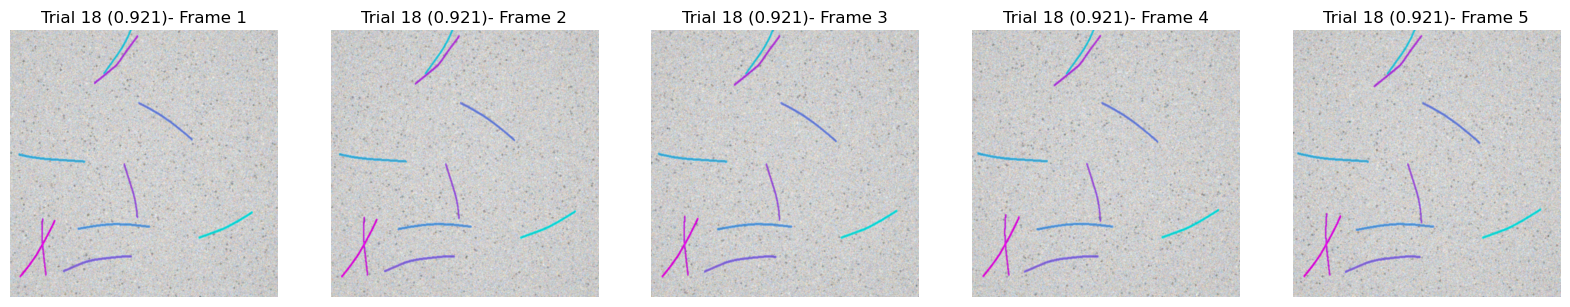

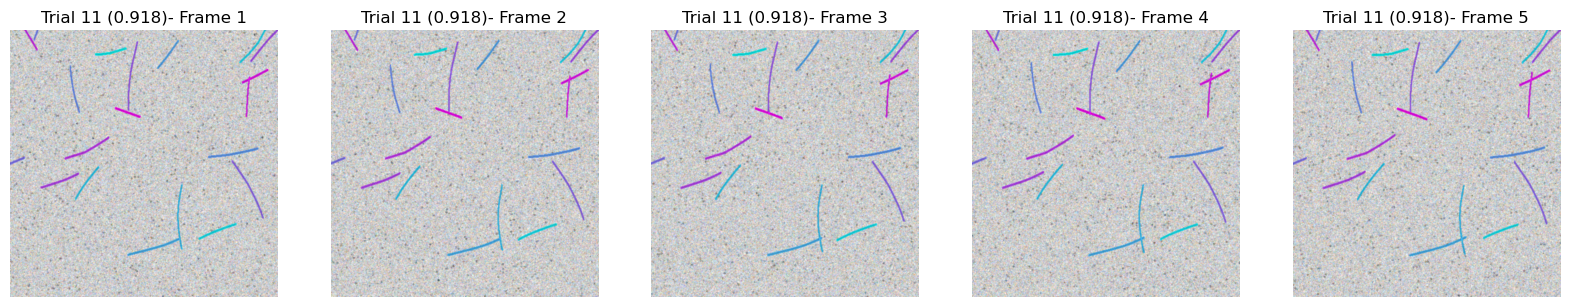

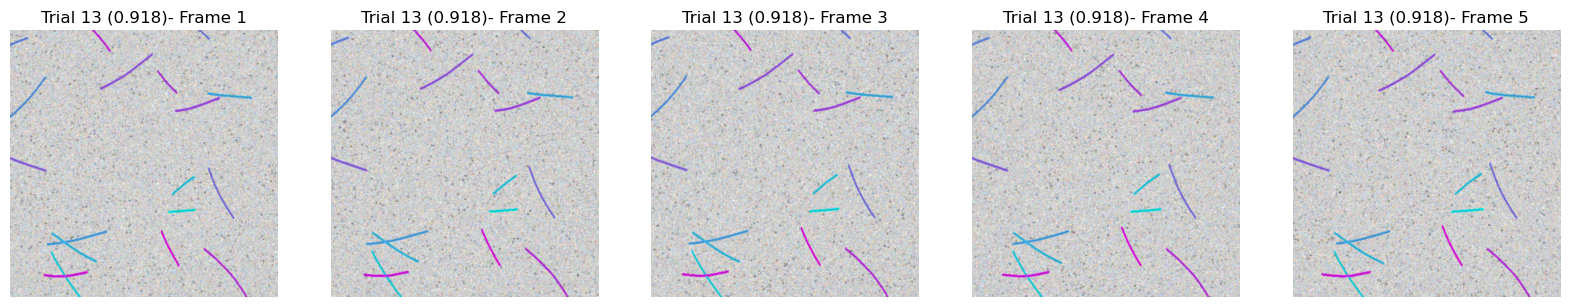

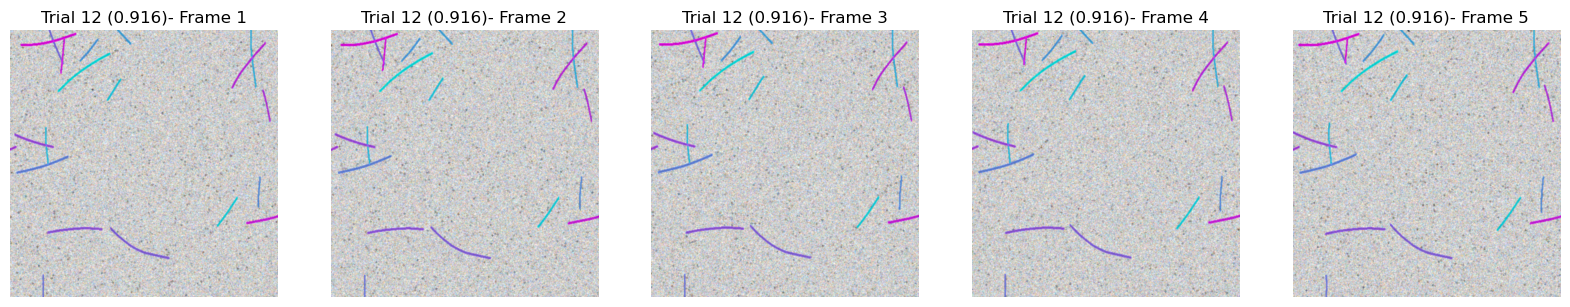

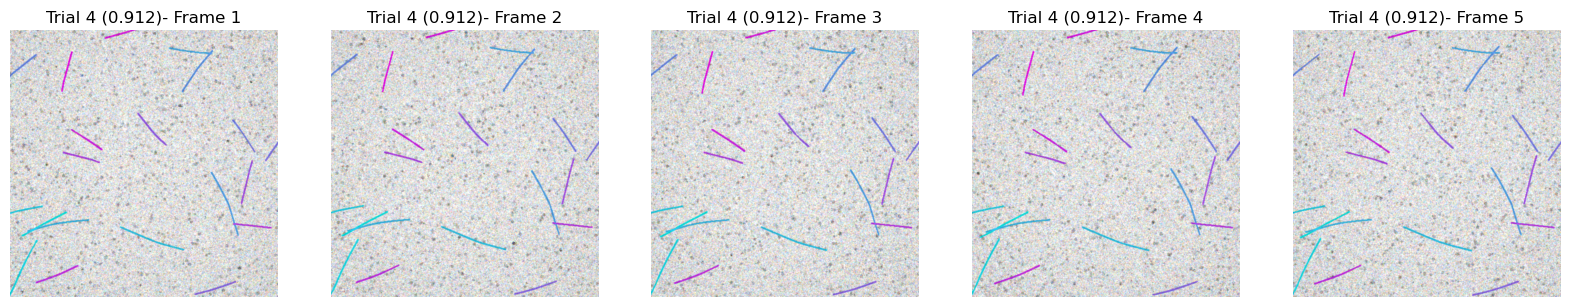

In [22]:
for current_frames, current_masks, trial in zip(frames, masks, top_trials):
    fig, axs = plt.subplots(1, 5, figsize=(20, 10))
    axs = axs.flatten()

    for ax, idx in zip(axs, range(len(frames))):
        overlay = create_overlay(current_frames[idx], current_masks[idx])

        ax.imshow(overlay)
        ax.axis("off")
        ax.set_title(f"Trial {trial.number+1} ({trial.value:.3f})- Frame {idx+1}")